In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from seispy.station.stationdata import SeismometerArray
from seispy.station import homestake
from scipy.linalg import pinv2,svd
from scipy.sparse.linalg import lsqr
import astropy.units as u
import numpy as np
import seispy.plotter.plot as hplot
import healpy as hp
import NX01_AnisCoefficients as anis
import AnisCoefficients_pix as pixAnis

/home/meyers/opt/seispy/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Injection
We'll inject a sine-wave with $f=1$ Hz with $10^{-4}$ m as the amplitude. 

We'll do an $r$-wave at $120^{\circ}$ North of East ($30^{\circ}$ WofN) and parallel to the surface and a $p$-wave at $60^{\circ}$ North of East ($30^{\circ}$ EofN) and $120^{\circ}$ down from the north pole ($60^{\circ}$ w.r.t. vertical, coming from below).

We'll assume we know the velocities: 5700 m/s for $p$-waves and 2500 m/s for $r$-waves. 

The $r$-wave phase-velocity is from the event catalogue estimates I gave a few weeks ago.

We'll use the full homestake seismometer array.

In terms of spherical harmonics, we can estimate from the velocity, frequency, and size of our array what the likely maximum $l$ value we'd be sensitive to is:

$$ l_{max} \approx \frac{\pi}{\theta} \approx \frac{2\pi d_{char} f}{v} \approx 4$$ 

where $v$ is the velocity of the wave, $d$ is the characteristic size of the array, and $f$ is the frequency of the wave.

The number of modes we're sensitive to is likely then $N_{modes}\approx l_{max}^2 \times N_{components} =128$.

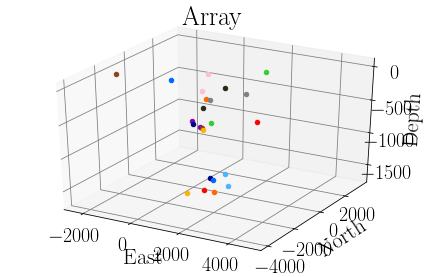

Approximate array size, d_{char}: 1970.592472 meters
lmax roughly is: 8
Spot size is: 0.352218


In [2]:
amplitude = 1e-4
strs = ['p','r']
# set up array
stations = homestake()
plot = stations.plot()
plt.title('Array')
plt.tight_layout()
plt.show()
#stations = homestake('underground')
distances = []
# get some white data
data = SeismometerArray.initialize_all_good(stations, 1000, chans_type='fast')
######### get spot size
snames = data.keys()
## get distance between station
for station in snames:
    for station2 in snames:
        diff_dir = np.asarray(stations[station]) -\
            np.asarray(stations[station2])
        distances.append(np.sqrt(np.dot(diff_dir,diff_dir)))
print 'Approximate array size, d_{char}: %f meters' % np.mean(distances)

spot_size = 5700 / (2 * 1 * np.max(distances))
lmax = int(np.pi / spot_size)
print 'lmax roughly is: %d' %  int(lmax)
print 'Spot size is: %f' % spot_size

In [3]:
# inject 1000s at 1 Hz
data.add_p_wave(amplitude, np.radians(60), np.radians(120), 1,1000, c=5700)
data.add_r_wave(amplitude, np.radians(120), np.radians(90), 0.1, 1000, 1, 1000, c=2500)

# Get cross-correlations

We now take the cross-correlation between stations:

$$Y_{(12)}(f) = \tilde{d}_1(f)^* \times \tilde{d}_2(f)$$

where $\tilde{d}_i(f)$ is the fast-fourier transform of data from seismometer channel $i$. 

In [4]:
# get coherences at 1 Hz
Ys = data.get_coherences(1, fftlength=100, overlap=50, window='hann')

# Get our overlap reduction function

We've shown in the past that if we're trying to estimate the power distribution on the sky, say $H_{S}(\hat\Omega)$ and we decompose that onto some orthonormal basis:

$$ H_{S}(\hat\Omega) = \sum_{a} B_a(\hat\Omega) S_a$$

then our cross-correlation statistic $Y_{(ij)}(f)$ between two arbitrary channels is related to those amplitude components as follows:

$$ Y_{ij}(f) = \sum_{a}\gamma_{(ij),a}S_a$$

In our case, we use pixels as our basis. However, it's useful to keep spherical harmonics in the back of your head as we do this (we'll discuss why later).

Note that $\gamma$ is related to the channel's response to a wave traveling in some direction (and can, in principle, also depend on the depth. This is true for $r$-waves in our model):

$$\gamma_{(ij),a} \equiv \int d\Omega \, B_a(\Omega)\, e_i(\Omega) \, e_j(\Omega) \, e^{2\pi i f(\hat\Omega\cdot\vec\Delta x)/v}$$

where $e_i(\Omega)$ is the dot product of the polarization of wave onto the channel. So for a $p$-wave traveling east and a channel pointing east, this is 1. For an $s$-wave traveling north with pure horizontal polarization and an east channel it is 1.

In our case, we use $B_a(\Omega) = \delta(\Omega,\Omega_0)$, which we call the "pixel basis."

Below we calculate $\gamma$ for each detector pair, and each direction for both $p$-waves and $r$-waves and then stack them.

In the end $G$ is a matrix with dimensions $N_{pairs} \times (2*N_{pixels})$ where the factor of 2 comes from the fact that we've got both $p$ and $r$-waves.

In [5]:
# get p-wave matrices
G2, phis2, thetas2, shapes2 = data.get_gamma_matrix_healpy('p',
        stations,1,5700)
# get r-wave matrices
G1, phis1, thetas1, shapes1 = data.get_gamma_matrix_healpy('r', stations,
        1, 2500)
# get shapes so that we can extract
# maps of different components at the end.
shapes = []
shapes.extend(shapes1)
shapes.extend(shapes2)
# stack matrices
G = np.vstack((G2, G1)).T
# Could start exceeding memory here
G2 = None
G1 = None
# combine angles associated with one axies
# of gamma matrices. keep track of
# shapes
phis = phis2
thetas = thetas2


['HHE', 'HHN', 'HHZ']
['HHE', 'HHN', 'HHZ']


# Maximum Likelihood Estimation

Our likelihood is simple: we insist that when we subtract the model from our data, we get back something consistent with gaussian noise in our channel:

$$ \log p(Y | S) = -\frac{1}{2} (\vec Y - \overleftrightarrow \gamma \vec S)^{\dagger} N^{-1} (\vec Y - \overleftrightarrow \gamma \vec S) $$

Where $N_{(ij),(i'j')} = \delta_{ii'}\delta_{jj'}(\sqrt{P_i(f)P_j(f)})$ is diagonal and proportional to the power in each individual seismometer.

This leads us to a maximum likelihood estimation for $\vec S$, which is what we want:

$$ S = (\gamma^\dagger \gamma)^{-1} \gamma^{\dagger} Y$$

We'll do this in two steps: we use a pseudo-inverse (using a singular-value decomposition) to do the matrix inversion, which we then multiply by $\gamma^{\dagger} Y$. 

That pseudo-inverse should have roughly $2 \times l_{max}^2 \approx 130$ non-zero singular values. Or, rather, that's roughly how many we should probably keep when we do the inversion. This can take some tuning if we want to use scipy's built-in *pinv2* function. I'll probably write one myself that keeps roughly that number of singular values in general.

However, when I do exactly what I say in the previous paragraph, the recovery introduces quite a bit of covariance into our maps between pixels and the recovery is poor. It's worth "playing around" with this condition in general and probably erring on the side of keeping fewer (although it could depend on the purpose). In this case, I keep only ~50 singular values of our matrix and we seem to get a good recovery. It does mean tuning lmax in our injection maps at the end, though

We can also calculate a detection statistic, which is the likelihood ratio between signal + noise and just noise:

$$ \log\epsilon = \log p(Y | S \neq 0) - \log p(Y | S = 0) = [(Y - \gamma S)^{\dagger} N^{-1} (Y -\gamma S)] - [(Y)^{\dagger} N^{-1} (Y)] $$

In [29]:
# do matrix inversion
Y = np.mean(Ys, 1)
N_inv = 1e24 * np.diag(np.ones(Y.size))
N = 1e-24 * np.diag(np.ones(Y.size))
X = np.real(np.dot(G.T,Y))
#    Gamma_pinv = pinv2(Gamma, rcond=1e-3)
G_pinv = pinv2(np.real(np.dot(G.T, G)), rcond=1e-2)
S = np.real(np.dot(G_pinv, X))

#S = lsqr(np.real(np.dot(G.T, G)), np.real(np.dot(G.T, Y)))[0]
#cov = np.real(np.dot(np.dot(G.T, N_inv), G))
cov=None
model = np.real(np.dot(G,S))
dat = (Y - model)
ll = -0.5 * np.real(np.dot(np.dot(dat.conj().T, N_inv), dat))
ll2 = -0.5 * np.real(np.dot(np.dot(Y.conj().T, N_inv), Y))
lratio = ll - ll2
print 'Log Likelihood ratio: %f' % lratio

Log Likelihood ratio: 29948872897090.031250


Rank of matrix is: 48


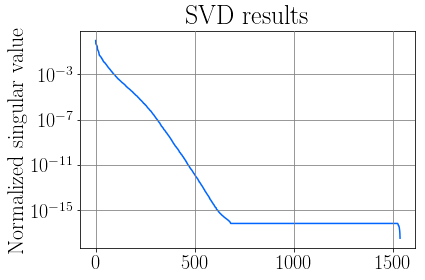

In [30]:
# do svd 
U,s,Vh = svd(np.dot(G.T,G))
# get rank using cutoff of 1e-2
rank = np.sum(s > 1e-2 * np.max(s))
print 'Rank of matrix is: %d' % rank
plt.figure()
plt.plot(s/max(s))
ax = plt.gca()
ax.set_yscale('log')
plt.ylabel('Normalized singular value')
plt.title('SVD results')
plt.show()

# Model Resolution Matrix

We can also calculate a model resolution matrix. If we assume that our data is given by convolving some "true" set of parameters with our beam pattern, then:

$$ Y = \gamma S_{true}$$

and we get our estimate from:

$$ S_{est} = (\gamma^{\dagger}\gamma)^{-1} \gamma^{\dagger}Y$$

then we see that:

$$ S_{est} = (\gamma^{\dagger}\gamma)^{-1} (\gamma^{\dagger}\gamma)S_{true} = \mathbb R S_{true}.$$

Note that there are 4 distinct blocks here coming from the two-distinct parts ($p$, $r$) of our $\gamma^{\dagger}\gamma$ matrix. Lower left is $p-p$ and upper right is $s-s$. It's nice to see things staying sane on the diagonals, although we do see some $p-s$ overlap in the off-diagonal blocks.


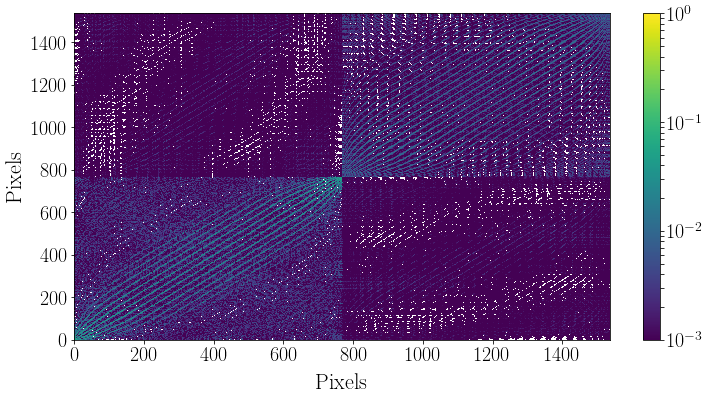

In [31]:
# Model resolution matrix
MRM = np.dot(G_pinv, np.real(np.dot(G.T, G)))
plt.figure(figsize=(12,6))
plt.pcolormesh(MRM, norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1))
plt.colorbar()
plt.xlabel('Pixels')
plt.ylabel('Pixels')
#plt.savefig('model_resolution_matrix')
plt.show()
MRM_diag = np.diag(MRM)

# Maps, recovery check

We can now create our maps and attempt to check how good our recovery is compared to expectation.

We do the latter by injecting into a single pixel, transforming into spherical harmonics, but only up to some $l_{max}$ consistent with our estimate at the very beginning. We then convert back to pixels. This way, we spread out our injection on the two-sphere in a way that we expect to be consistent with what our array is capable of recovering. We can then calculate a cross-power estimate of our recovered map onto this "injection" map to calculate a "match parameter" that is 1 for a perfect match:

$$ M = (S_{rec} \cdot S_{inj}) / \sqrt{(S_{rec}\cdot S_{rec})(S_{inj}\cdot S_{inj})}.$$

It can take some tuning of $l_{max}$ for the injection map sometimes (especially depending on your singular-value cutoff), which can also tell us more info about our array. In this case, it's a bit surprising to me that $l_{max}$ for the $p$ map is larger, since it's spot size should in principle be larger than that for $s$ (because its velocity is larger).

I also only consider horizontal pixels for the $s$-wave comparison since the injection will inject a spot in a map, but we'd recovery a slice in azimuth (but roughly uniform in polar angle).

In this case the best match parameters I got were 0.76 for $p$ and 0.85 for $r$. When I just recover $p$ by itself, I often get something like 0.95.

It would be interesting to try restricting the $r$-wave matrices to only horizontal plane when doing recovery.

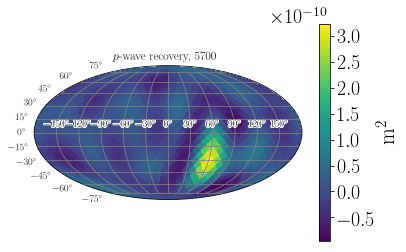

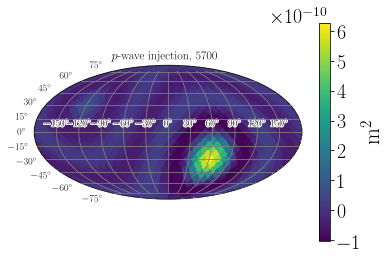

Match parameter: 0.762063
768


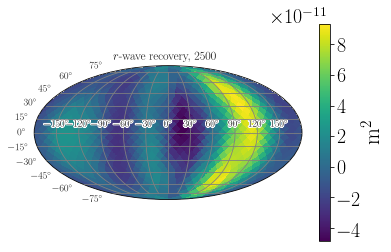

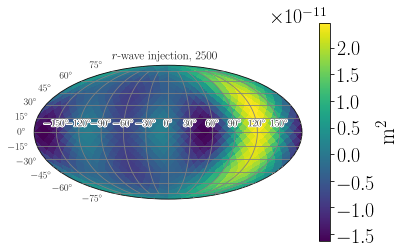

Match parameter: 0.716202


In [35]:
# set some parameters for injections
idx0=0
vlist=[5700,2500]
phi_injs = [60,120]
theta_injs = [120, 90]
inj_powers = [1e-4, 1e-4, 0]

# loop over components
for ii,shape in enumerate(shapes):
    # get shape, get the phis and thetas
    # for this particular map.
    shape = shape[0]
    phis_temp = phis[idx0:idx0+shape]
    thetas_temp = thetas[idx0:idx0+shape]
    # Extract this map.
    S_temp = S[idx0:idx0+shape] / 100
    inj_map = np.zeros(S_temp.shape)
    inj_map_ini = np.zeros(S_temp.shape)
    nside = 8
    
    # Create an injection map:
    # 1. add power to single pixel associated with sky direction
    # 2. convert to spherical harmonics, but only use up lmax
    #     associated with expected spot size
    # 3. convert back to pixel basis
    # For r-waves we inject at every value of the polar angle, since we're insensitive to polar angle.
    uni_thetas = np.unique(thetas)
    unts = uni_thetas.size
    if strs[ii] == 'r':
        horiz_pixels = hp.pixelfunc.ang2pix(nside, np.pi / 2, phis)
        for jj in xrange(uni_thetas.size):
            idx = hp.pixelfunc.ang2pix(nside, uni_thetas[jj], np.radians(phi_injs[ii]))
            inj_map_ini[idx] = 1
        #idx = hp.pixelfunc.ang2pix(nside, np.radians(theta_injs[ii]), np.radians(phi_injs[ii]))
        #inj_map_ini[idx] = 1
        P_inj = pixAnis.clmFromMap(inj_map_ini, lmax - 5) * (inj_powers[ii]/(np.pi / spot_size))**2
        P_inj[0] = 1e-12
        inj_map = pixAnis.mapFromClm(P_inj, nside)
        # just get horizontal stuff
        inj_horiz = inj_map[horiz_pixels]
        print inj_horiz.size
        S_horiz = S_temp[horiz_pixels]
        phis_idxs = np.argsort(phis)
        S_horiz = np.zeros(np.unique(phis).size)
        inj_horiz = np.zeros(np.unique(phis).size)
        phis_uni = np.unique(phis)
        for kk,phi in enumerate(np.sort(phis_uni)):
            for theta in uni_thetas:
                idx = hp.pixelfunc.ang2pix(nside, theta, phi)
                S_horiz[kk] += S_temp[idx]
                inj_horiz[kk] += inj_map[idx]
        phis_horiz_idxs = np.argsort(phis_uni)
        phis_horiz = phis_uni[phis_horiz_idxs]
    else:
        idx = hp.pixelfunc.ang2pix(nside, np.radians(theta_injs[ii]), np.radians(phi_injs[ii]))
        inj_map[idx] = 1
        P_inj = pixAnis.clmFromMap(inj_map, lmax-2) * (inj_powers[ii])**2
        P_inj[0] = 1e-12
        inj_map = pixAnis.mapFromClm(P_inj, nside)
    
    if False: #strs[ii] == 'r':
        idx_sort = np.argsort(phis)
        plt.plot(np.degrees(phis_horiz), S_horiz, label='Recovery')
        ax = plt.gca()
        ax.plot(np.degrees(phis_horiz), inj_horiz, label='Injection')
        ax.set_xlabel('$\phi$ [North of East]')
        ax.set_ylabel('m$^2$')
        ax.set_ylim(-2.5e-9, 2.5e-9)
        plt.title('$r$-wave recovery')
        plt.tight_layout()
        plt.legend()
        plt.show()
        match = np.dot(inj_horiz, S_horiz) / np.sqrt(np.dot(inj_horiz,inj_horiz) *
                np.dot(S_horiz, S_horiz))
        print 'Match parameter: %f' % match
    else:
        # plot recovery map
        ax = plt.subplot(111, projection='mollweide')
        hplot.healpix_heatmap(S_temp, cmap='viridis')
        hplot.outline_text(ax)
        ax.grid(True)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(10)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(10)
        plt.colorbar(label='m$^2$')
        ax.set_title(r'$%s$-wave recovery, %d' % (strs[ii], vlist[ii]), fontsize=12)
        #plt.savefig('%s_recovery' % (strs[ii]))
        #plt.close()
        plt.show()


        # plot injection map
        ax = plt.subplot(111, projection='mollweide')
        hplot.healpix_heatmap(inj_map, cmap='viridis')
        hplot.outline_text(ax)
        ax.grid(True)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(10)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(10)
        plt.colorbar(label='m$^2$')
        ax.set_title(r'$%s$-wave injection, %d' % (strs[ii],vlist[ii]), fontsize=12)
        plt.show()
    
    # Calculate projection of recovered map onto injected map
        match = np.dot(inj_map, S_temp) / np.sqrt(np.dot(inj_map,inj_map) *
                np.dot(S_temp, S_temp))
        print 'Match parameter: %f' % match
    idx0+=shape